# Lab 8


## Setup for SUSY Dataset

Use the SUSY dataset for the rest of this lab. Here is a basic setup.

In [1]:
# Our usual libraries...
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML, display
import tabulate

import sklearn.discriminant_analysis as DA
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

In [3]:
! wc -l SUSY-small.csv

  500000 SUSY-small.csv


In [5]:
VarNames=["signal", "l_1_pT", "l_1_eta","l_1_phi", "l_2_pT", "l_2_eta", "l_2_phi", "MET", "MET_phi", "MET_rel", "axial_MET", "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos_theta_r1"]

In [7]:
filename = "SUSY-small.csv"
df = pd.read_csv(filename, dtype='float64', names=VarNames)

df_sig=df[df.signal==1]
df_bkg=df[df.signal==0]

In [8]:
RawNames=["l_1_pT", "l_1_eta","l_1_phi", "l_2_pT", "l_2_eta", "l_2_phi", "MET", "MET_phi"]
FeatureNames=list(set(VarNames[1:]).difference(RawNames))

## Scikit-Learn

[Scikit-learn](http://scikit-learn.org) is a rich python library for data science, including machine learning. For example, we can build a Fisher Discriminant (aka Linear Discriminant Analysis, or LDA). 

### Exercise 1: Install Scikit-Learn

Follow the [Installation Instructions](https://scikit-learn.org/stable/install.html) and install `scikit-learn` in your environment.

In [12]:
import sklearn

### Exercise 2: Read About Classifiers

#### Part a
Scikit-learn offers an impressively comprehensive list of machine learning algorithms. Browse through [scikit-learn's documentation](https://scikit-learn.org/stable/index.html). You'll note the algorithms are organized into classification, regression, clustering, dimensionality reduction, model selection, and preprocessing. Browse through the list of [classification algorithms](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning). 

#### Part b
Note scikit-learn's documentation is rather comprehensive. The documentation on [linear models](https://scikit-learn.org/stable/modules/linear_model.html) shows how classification problems are setup. Read about the first few methods and try to comprehend the example codes. Skim the rest of the document.

#### Part c
Read through the [LDA Documentation](https://scikit-learn.org/stable/modules/lda_qda.html).


### Exercise 3: Training a Classifier

Lets' repeat what we did manually in the previous lab using scikit-learn. We'll use a LDA classifier, which we can instanciate as follows:

In [16]:
import sklearn.discriminant_analysis as DA
Fisher=DA.LinearDiscriminantAnalysis()

As discussed in the lecture, to properly formulate our problem, we'll have to:

* Define the inputs (X) vs outputs (Y)
* Designate training vs testing samples (in order to get a unbias assessment of the performance of Machine Learning algorithms)

for example, here we'll take use 4M events for training and the remainder for testing.

In [19]:
N_Train=400000

Train_Sample=df[:N_Train]
Test_Sample=df[N_Train:]

X_Train=Train_Sample[VarNames[1:]]
y_Train=Train_Sample["signal"]

X_Test=Test_Sample[VarNames[1:]]
y_Test=Test_Sample["signal"]

Test_sig=Test_Sample[Test_Sample.signal==1]
Test_bkg=Test_Sample[Test_Sample.signal==0]


We can train the classifier as follow:

In [22]:
Fisher.fit(X_Train,y_Train)

LinearDiscriminantAnalysis()

We can plot the output, comparing signal and background:

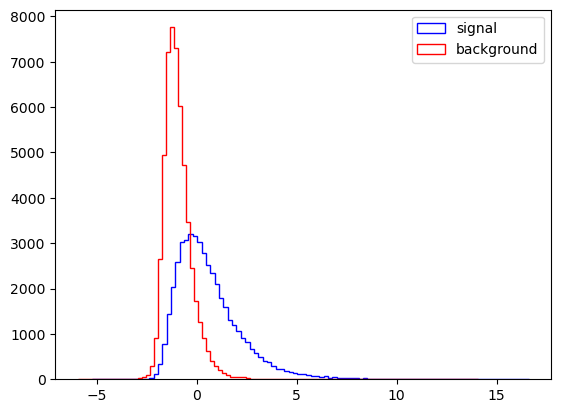

In [25]:
plt.figure()
plt.hist(Fisher.decision_function(Test_sig[VarNames[1:]]),bins=100,histtype="step", color="blue", label="signal",stacked=True)
plt.hist(Fisher.decision_function(Test_bkg[VarNames[1:]]),bins=100,histtype="step", color="red", label="background",stacked=True)
plt.legend(loc='upper right')
plt.show()

#### Part a

Compare ROC curves computed on the test versus training samples, in a single plot. Do you see a bias?

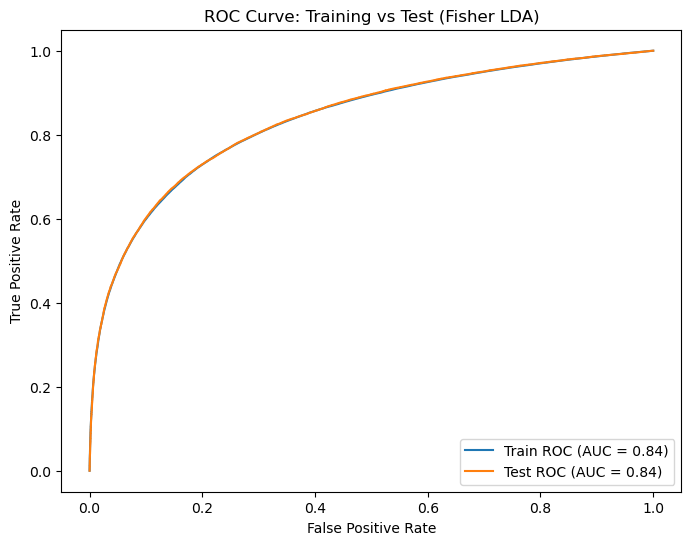

In [28]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_train_score = Fisher.decision_function(X_Train)
y_test_score  = Fisher.decision_function(X_Test)

fpr_train, tpr_train, _ = roc_curve(y_Train, y_train_score)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_Test, y_test_score)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(8,6))
plt.plot(fpr_train, tpr_train, label="Train ROC (AUC = {:.2f})".format(roc_auc_train))
plt.plot(fpr_test, tpr_test, label="Test ROC (AUC = {:.2f})".format(roc_auc_test))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Training vs Test (Fisher LDA)")
plt.legend(loc="lower right")
plt.show()

#### Part b

Train the Fisher performance of using the raw, features, and raw+features as input. Compare the performance one a single plot. 

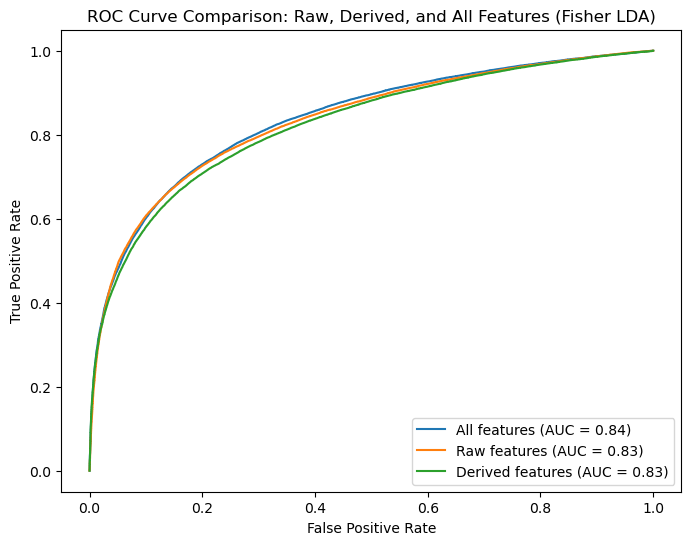

In [31]:
import sklearn.discriminant_analysis as DA

X_Train_raw  = Train_Sample[RawNames]
X_Train_feat = Train_Sample[FeatureNames]

X_Test_raw   = Test_Sample[RawNames]
X_Test_feat  = Test_Sample[FeatureNames]

Fisher_all  = DA.LinearDiscriminantAnalysis().fit(Train_Sample[VarNames[1:]], y_Train)
Fisher_raw  = DA.LinearDiscriminantAnalysis().fit(X_Train_raw, y_Train)
Fisher_feat = DA.LinearDiscriminantAnalysis().fit(X_Train_feat, y_Train)

score_all  = Fisher_all.decision_function(X_Test)
score_raw  = Fisher_raw.decision_function(X_Test_raw)
score_feat = Fisher_feat.decision_function(X_Test_feat)

fpr_all, tpr_all, _   = roc_curve(y_Test, score_all)
auc_all = auc(fpr_all, tpr_all)

fpr_raw, tpr_raw, _   = roc_curve(y_Test, score_raw)
auc_raw = auc(fpr_raw, tpr_raw)

fpr_feat, tpr_feat, _ = roc_curve(y_Test, score_feat)
auc_feat = auc(fpr_feat, tpr_feat)

plt.figure(figsize=(8,6))
plt.plot(fpr_all, tpr_all, label="All features (AUC = {:.2f})".format(auc_all))
plt.plot(fpr_raw, tpr_raw, label="Raw features (AUC = {:.2f})".format(auc_raw))
plt.plot(fpr_feat, tpr_feat, label="Derived features (AUC = {:.2f})".format(auc_feat))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison: Raw, Derived, and All Features (Fisher LDA)")
plt.legend(loc="lower right")
plt.show()

### Exercise 4: Comparing Techniques

#### Part a
Select 3 different classifiers from the techniques listed [here](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning) to compare. Note that you can use the multi-layer perceptron to build a deep network, though training may be prohibitively slow. So avoid this technique.

#### Part b

Write a function that takes an instantiated classifier and performs the comparison from part 3b. Use the function on your choice of functions in part a.

#### Part c

Use the best method from part c to compute the maximal significance $\sigma_S= \frac{N_S}{\sqrt{N_S+N_B}}$ for the scenarios in lab 5.

# A

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


clf_lr  = LogisticRegression(max_iter=1000)
clf_svc = SVC(probability=True)

# B

In [38]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.base import clone

def compare_feature_sets(classifier, 
                         X_Train_all, X_Test_all,
                         X_Train_raw, X_Test_raw,
                         X_Train_feat, X_Test_feat,
                         y_Train, y_Test):
    feature_sets = {
        'All':   (X_Train_all, X_Test_all),
        'Raw':   (X_Train_raw, X_Test_raw),
        'Derived': (X_Train_feat, X_Test_feat)
    }
    
    auc_scores = {}
    
    plt.figure(figsize=(8,6))
    
    for name, (X_train, X_test) in feature_sets.items():
        clf = clone(classifier)
        clf.fit(X_train, y_Train)
        
        if hasattr(clf, "decision_function"):
            y_scores = clf.decision_function(X_test)
        else:
            y_scores = clf.predict_proba(X_test)[:, 1]
        
        fpr, tpr, _ = roc_curve(y_Test, y_scores)
        roc_auc = auc(fpr, tpr)
        auc_scores[name] = roc_auc
        
        plt.plot(fpr, tpr, label=f"{name} features (AUC = {roc_auc:.2f})")
    
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve Comparison ({classifier.__class__.__name__})')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
    
    return auc_scores

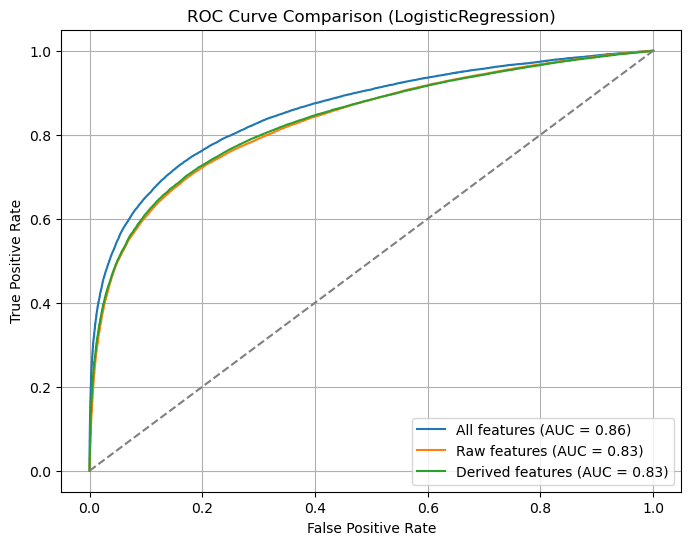

AUC Scores by Feature Set:
All: 0.8587
Raw: 0.8327
Derived: 0.8349


In [40]:
from sklearn.linear_model import LogisticRegression

clf_lr  = LogisticRegression(max_iter=1000)

auc_results = compare_feature_sets(
    classifier=clf_lr,
    X_Train_all=X_Train,
    X_Test_all=X_Test,
    X_Train_raw=X_Train_raw,
    X_Test_raw=X_Test_raw,
    X_Train_feat=X_Train_feat,
    X_Test_feat=X_Test_feat,
    y_Train=y_Train,
    y_Test=y_Test
)

print("AUC Scores by Feature Set:")
for k, v in auc_results.items():
    print(f"{k}: {v:.4f}")

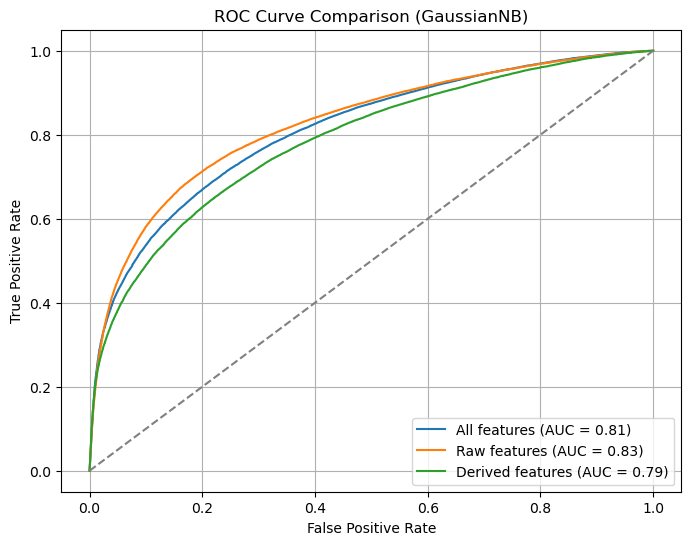

AUC Scores by Feature Set:
All: 0.8122
Raw: 0.8258
Derived: 0.7870


In [44]:
from sklearn.naive_bayes import GaussianNB

clf_gnb = GaussianNB()

auc_results = compare_feature_sets(
    classifier=clf_gnb,
    X_Train_all=X_Train,
    X_Test_all=X_Test,
    X_Train_raw=X_Train_raw,
    X_Test_raw=X_Test_raw,
    X_Train_feat=X_Train_feat,
    X_Test_feat=X_Test_feat,
    y_Train=y_Train,
    y_Test=y_Test
)

print("AUC Scores by Feature Set:")
for k, v in auc_results.items():
    print(f"{k}: {v:.4f}")

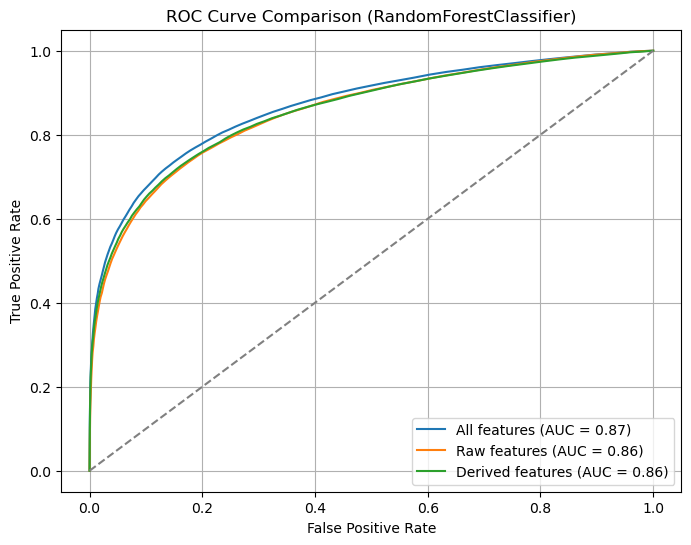

AUC Scores by Feature Set:
All: 0.8687
Raw: 0.8552
Derived: 0.8570


In [42]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=42)

auc_results = compare_feature_sets(
    classifier=clf,
    X_Train_all=X_Train,
    X_Test_all=X_Test,
    X_Train_raw=X_Train_raw,
    X_Test_raw=X_Test_raw,
    X_Train_feat=X_Train_feat,
    X_Test_feat=X_Test_feat,
    y_Train=y_Train,
    y_Test=y_Test
)

print("AUC Scores by Feature Set:")
for k, v in auc_results.items():
    print(f"{k}: {v:.4f}")

# C

In [27]:
def compute_max_significance(clf, X_test, y_test):
    scores = clf.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else clf.decision_function(X_test)
    
    thresholds = np.linspace(scores.min(), scores.max(), 1000)
    best_sigma = 0
    best_thresh = thresholds[0]
    best_Ns, best_Nb = 0, 0
    for thresh in thresholds:
        pred_signal = scores > thresh
        Ns = ((y_test == 1) & pred_signal).sum()
        Nb = ((y_test == 0) & pred_signal).sum()
        if (Ns + Nb) > 0:
            sigma = Ns / np.sqrt(Ns + Nb)
        else:
            sigma = 0
        if sigma > best_sigma:
            best_sigma = sigma
            best_thresh = thresh
            best_Ns = Ns
            best_Nb = Nb
    return best_sigma, best_thresh, best_Ns, best_Nb

# Demonstration: Use the Random Forest classifier trained on all features.
clf_rf_all = clone(clf_rf)
clf_rf_all.fit(Train_Sample[VarNames[1:]], y_Train)
best_sigma, best_thresh, best_Ns, best_Nb = compute_max_significance(clf_rf_all, X_Test, y_Test)
print("Maximal significance: {:.3f} at threshold {:.3f} with Ns = {} and Nb = {}".format(
      best_sigma, best_thresh, best_Ns, best_Nb))

Maximal significance: 525.408 at threshold 0.400 with Ns = 360363 and Nb = 110058


### Exercise 5: Metrics

Scikit-learn provides methods for computing the FPR, TPR, ROC, AUC metrics. For example:

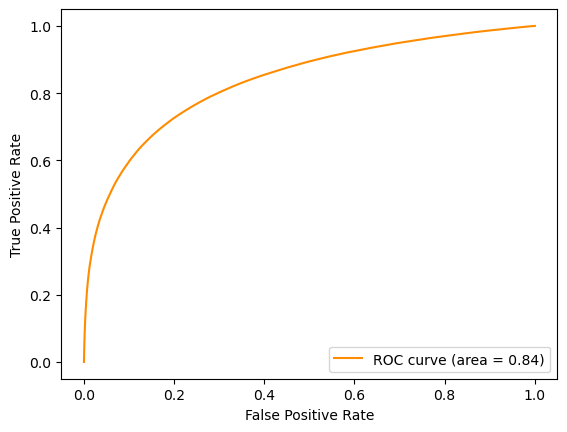

In [32]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_Test, Fisher.decision_function(X_Test))

roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr,color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()


#### Part a
TPR/FPR/ROC/AUC are one way of assessing the quality of a classifier. Read about [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall), [Accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision), and [F-score](https://en.wikipedia.org/wiki/F-score).

#### Part b
Look through [model evaluation](https://scikit-learn.org/stable/modules/model_evaluation.html#) documentation. Using scikit-learns tools, compute TPR, FPR, ROC, AUC, Precision, Recall, F1 score, and accuracy for the method you selected in 4c above and each scenario. Make a nice table, which also includes the maximal significance. 


# B

In [50]:
from sklearn.metrics import (
    roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
)
import numpy as np

def compute_classifier_metrics(clf, X_test, y_test):
    """
    Computes TPR, FPR, ROC, AUC, Precision, Recall, F1, Accuracy, and Maximal Significance.
    """
    if hasattr(clf, "predict_proba"):
        scores = clf.predict_proba(X_test)[:, 1]
    else:
        scores = clf.decision_function(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, scores)
    roc_auc = auc(fpr, tpr)
    
    max_sigma = 0
    best_thresh = 0
    best_Ns = best_Nb = 0

    for thresh in thresholds:
        pred = scores > thresh
        Ns = ((y_test == 1) & pred).sum()
        Nb = ((y_test == 0) & pred).sum()
        if (Ns + Nb) > 0:
            sigma = Ns / np.sqrt(Ns + Nb)
            if sigma > max_sigma:
                max_sigma = sigma
                best_thresh = thresh
                best_Ns = Ns
                best_Nb = Nb

    y_pred = scores > best_thresh
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    metrics = {
        "AUC": roc_auc,
        "TPR (Recall)": recall_score(y_test, y_pred),
        "FPR": fp / (fp + tn),
        "Precision": precision_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "Accuracy": accuracy_score(y_test, y_pred),
        "Max Significance": max_sigma,
        "Best Threshold": best_thresh,
        "Ns": best_Ns,
        "Nb": best_Nb
    }
    
    return metrics


In [52]:
metrics_all  = compute_classifier_metrics(clf_rf_all, X_Test, y_Test)
metrics_raw  = compute_classifier_metrics(clf_rf_raw, X_Test_raw, y_Test)
metrics_feat = compute_classifier_metrics(clf_rf_feat, X_Test_feat, y_Test)

import pandas as pd

summary_df = pd.DataFrame({
    'Scenario': ['Raw features', 'Derived features', 'All features'],
    'AUC': [metrics_raw['AUC'], metrics_feat['AUC'], metrics_all['AUC']],
    'TPR (Recall)': [metrics_raw['TPR (Recall)'], metrics_feat['TPR (Recall)'], metrics_all['TPR (Recall)']],
    'FPR': [metrics_raw['FPR'], metrics_feat['FPR'], metrics_all['FPR']],
    'Precision': [metrics_raw['Precision'], metrics_feat['Precision'], metrics_all['Precision']],
    'F1 Score': [metrics_raw['F1 Score'], metrics_feat['F1 Score'], metrics_all['F1 Score']],
    'Accuracy': [metrics_raw['Accuracy'], metrics_feat['Accuracy'], metrics_all['Accuracy']],
    'Max Significance': [metrics_raw['Max Significance'], metrics_feat['Max Significance'], metrics_all['Max Significance']]
})

print(summary_df.to_string(index=False))

        Scenario      AUC  TPR (Recall)      FPR  Precision  F1 Score  Accuracy  Max Significance
    Raw features 0.855874      0.787659 0.237856   0.737962  0.762001   0.77387        163.444894
Derived features 0.857193      0.774081 0.219167   0.750232  0.761970   0.77773        163.371517
    All features 0.869031      0.792532 0.215947   0.757350  0.774542   0.78795        166.089504
